# Lesson 3: Model Interpretability

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
import os
sys.path.insert(0, "/Users/JI/Documents/Github/fastai/old/")
# print(sys.path)
import fastai
print(sys.modules['fastai'])

<module 'fastai' from '/Users/JI/Documents/Github/fastai/old/fastai/__init__.py'>


In [15]:
from fastai.structured import *
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import math

In [6]:
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn,nas= proc_df(df_raw,'SalePrice')

In [14]:
def split_vals(a,n): return a[:n],a[n:]
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn,n_trn)
y_train, y_valid = split_vals(y_trn,n_trn)
raw_train, raw_valid = split_vals(df_raw,n_trn)
X_train.shape,y_train.shape,y_train.shape,y_valid.shape,raw_train.shape

((389125, 66), (389125,), (389125,), (12000,), (389125, 65))

In [17]:
def rmse(predicted,actual): return math.sqrt(((predicted-actual)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

### Confidence based on tree variance
take std of the average of the predictions across each of the trees

In [18]:
set_rf_samples(50_000)

In [20]:
%time
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=4)
m.fit(X_train,y_train)
print_score(m)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs
[0.2211535350627861, 0.2554626549709594, 0.8977831254137735, 0.8834525390062813]


In [26]:
%time
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [36]:
X_valid

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
389125,4364751,2300944,665,172,1.0,1999,3726.0,2,3232,1111,...,259,False,False,False,False,False,False,1284595200,False,False
389126,4364757,1265434,12042,172,1.0,1996,5809.0,2,3234,1112,...,343,False,False,False,False,False,False,1291852800,False,False
389127,4364774,2005935,9218,172,1.0,1993,0.0,-1,3238,1115,...,218,False,False,False,False,False,False,1281052800,False,False
389128,4364807,2296707,668,172,1.0,2000,1789.0,2,3242,1116,...,349,False,False,False,False,False,False,1292371200,False,False
389129,4364811,1403366,9219,172,1.0,1999,0.0,-1,3241,1116,...,161,False,False,False,False,False,False,1244592000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,1840702,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401121,6333337,1830472,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401122,6333338,1887659,21439,149,1.0,2005,0.0,-1,657,207,...,306,False,False,False,False,False,False,1320192000,False,True
401123,6333341,1903570,21435,149,2.0,2005,0.0,-1,483,159,...,298,False,False,False,False,False,False,1319500800,False,True


#### predictions
- val set contains 12k rows (obsv) with 66 features
- preds takes the predictions of each of the 40 specificed trees (n_estimators)
    - 40 rows for each tree, 12k cols (each tree contains the average value of each of the 12k obs in the validation set
    

In [37]:
display(preds.shape,preds)

(40, 12000)

array([[ 9.20681,  9.318  ,  9.51205, ...,  9.31915,  9.12203,  9.12203],
       [ 9.042  ,  9.60983,  9.24932, ..., 10.63311,  9.07292,  9.07292],
       [ 9.04724,  9.00145,  9.04724, ...,  9.19557,  9.63732,  9.63732],
       ...,
       [ 9.12197,  9.39838,  9.09978, ...,  9.42986,  9.42986,  9.42986],
       [ 9.1185 ,  9.88894,  9.00051, ...,  9.26753,  9.03163,  9.03163],
       [ 9.25693,  9.06223,  9.02918, ...,  9.06816, 10.20599, 10.20599]])

In [43]:
display(np.mean(preds[:,0])) # the mean of all the trees, for the 1st observation
display(np.std(preds[:,0])) # the std of all the trees, for the 1st observation

9.323783383714574

0.3652902969823836

#### Parallelize the predictions operation

In [44]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 76.1 ms, sys: 65.1 ms, total: 141 ms
Wall time: 1.1 s


(9.323783383714574, 0.3652902969823836)

In [45]:
raw_valid 

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
389125,4364751,9.104980,2300944,665,172,1.0,1999,3726.0,2,KX1212,...,16,3,259,False,False,False,False,False,False,1284595200
389126,4364757,9.047821,1265434,12042,172,1.0,1996,5809.0,2,KX151,...,9,3,343,False,False,False,False,False,False,1291852800
389127,4364774,9.104980,2005935,9218,172,1.0,1993,0.0,-1,KX41,...,6,4,218,False,False,False,False,False,False,1281052800
389128,4364807,9.259131,2296707,668,172,1.0,2000,1789.0,2,KX612,...,15,2,349,False,False,False,False,False,False,1292371200
389129,4364811,9.104980,1403366,9219,172,1.0,1999,0.0,-1,KX61,...,10,2,161,False,False,False,False,False,False,1244592000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


#### Visualize confidence intervals by columns
- looking to see which cols contain data, etc

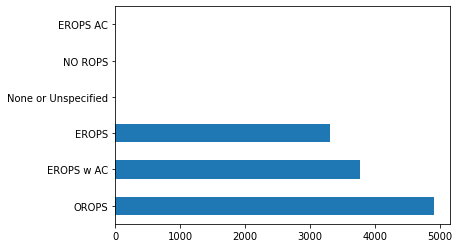

In [66]:
valid_copy = raw_valid.copy()
valid_copy['pred_std'] = np.std(preds, axis=0) # down all the trees
valid_copy['pred'] = np.mean(preds, axis=0)
valid_copy.Enclosure.value_counts().plot.barh();

##### Side note - seeing how axis=0, and axis=1 affect things
- axis=0 down rows
- axis=1 across cols

In [62]:
test = np.array([[1,1],[2,2]])
test

array([[1, 1],
       [2, 2]])

In [64]:
axis0 = np.mean(test,axis=0)
axis1 = np.mean(test,axis=1)
axis0, axis0.shape, axis1, axis1.shape

(array([1.5, 1.5]), (2,), array([1., 2.]), (2,))

#### see how Enclosure and SalePrice are related

In [68]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = valid_copy[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.845262,0.288425
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.569930,0.278594
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.688937,0.232535


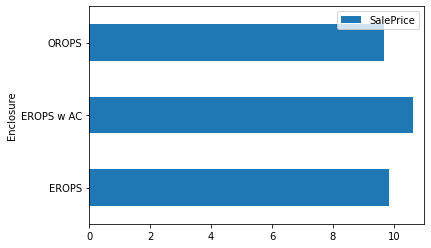

In [69]:
# enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

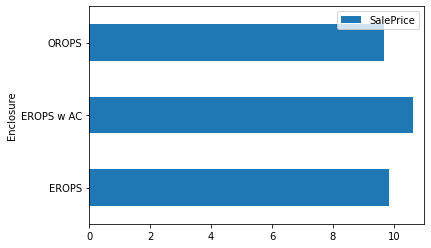

In [70]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

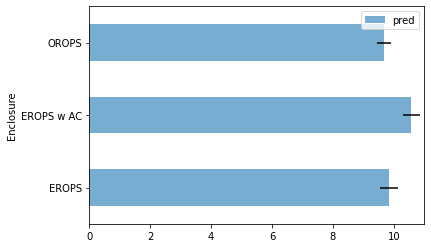

In [71]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

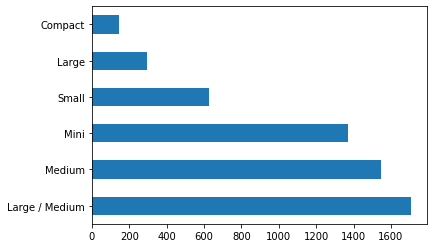

In [72]:
raw_valid.ProductSize.value_counts().plot.barh();

In [74]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = valid_copy[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.873523,0.384879
Large,10.470589,10.374297,0.365014
Large / Medium,10.691871,10.644506,0.307440
Medium,10.681511,10.623417,0.301228
Mini,9.535147,9.571541,0.271905
Small,10.324448,10.315921,0.329704


In [75]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.038981
Large             0.035184
Small             0.031961
Large / Medium    0.028882
Mini              0.028408
Medium            0.028355
dtype: float64

### Feature Importance
- which columns matter
- Data Leakage: having access to information during model development that you wouldn't have during actual decision making
- look at top10 features and try to understand more deeply
- removing reduntant cols might make predictions a little bit better, also removing colinearity (cols related to each other)
- Feature Importance: take one col and randomly shuffle so it has no relationship to the dependent variable. Then run predictions on the trained model

In [76]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.170674
37,Coupler_System,0.124255
13,ProductSize,0.111131
14,fiProductClassDesc,0.081297
2,ModelID,0.049992
63,saleElapsed,0.048256
10,fiSecondaryDesc,0.044159
38,Grouser_Tracks,0.042689
19,Enclosure,0.038755
9,fiBaseModel,0.028536


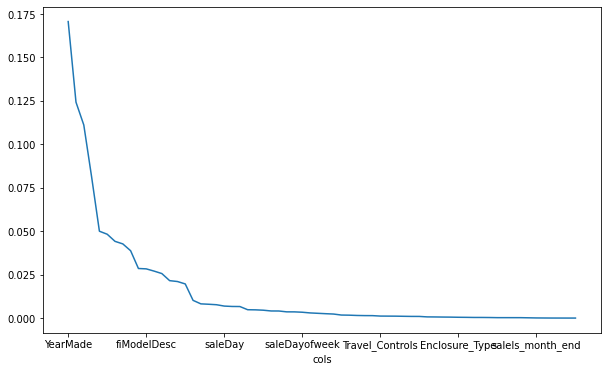

In [77]:
fi.plot('cols','imp',figsize=(10,6),legend=False)

In [78]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

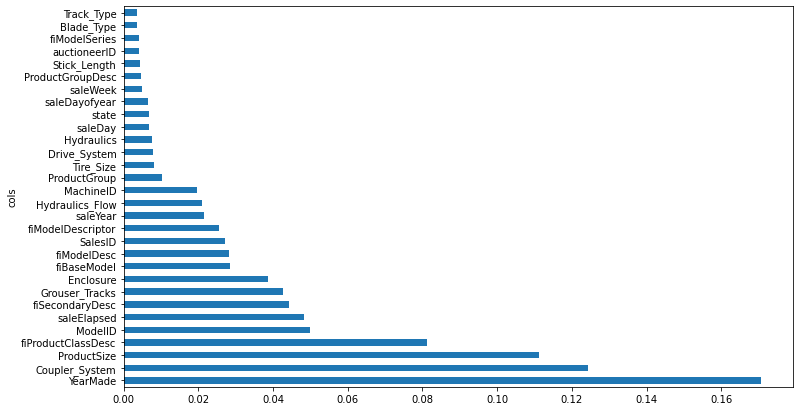

In [79]:
plot_fi(fi[:30])

In [80]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [81]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [82]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=4)
m.fit(X_train,y_train)
print_score(m)

[0.22179200196560808, 0.25321495000156047, 0.8971920763342389, 0.8854944175124276]


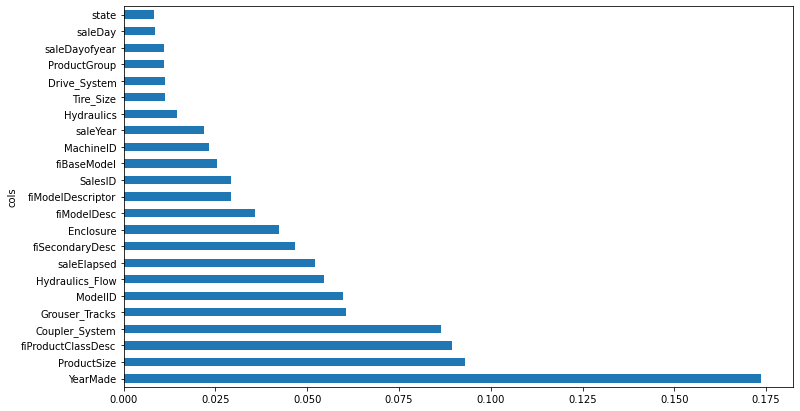

In [83]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);